# The Anatomy of a Blockbuster: TMDB Movie Analysis
## A Data-Driven Exploration of What Makes Movies Successful

### Introduction and Motivation

This notebook conducts an in-depth exploratory data analysis (EDA) of the TMDB 5000 Movie Dataset to uncover the key factors that contribute to a film's financial success. In an industry characterized by high risks and high rewards, data-driven insights are crucial for understanding the dynamics of blockbuster filmmaking.

**The compelling question we seek to answer: "What can we say about the success of a movie before it is released?"**

---

### Key Research Questions

Our analysis is structured around these critical questions:
* What is the relationship between a movie's budget and its box office revenue?
* Which movie genres are the most financially efficient and profitable?
* How have the economics of filmmaking evolved over time?
* What key factors show the strongest correlation with a movie's financial success?

---

### Data Source

This analysis utilizes the "TMDB 5000 Movie Dataset," sourced from The Movie Database (TMDb) and made available on Kaggle. The dataset consists of two main files containing detailed information on 5,000 movies, including budget, revenue, genres, cast, and crew.

---

### Project Structure

This analysis follows a clear workflow:
1. **Data Ingestion** - Loading and merging the datasets
2. **Data Cleaning** - Handling missing values and data type conversions
3. **Feature Engineering** - Creating new meaningful variables
4. **Exploratory Analysis** - Uncovering patterns and insights
5. **Visualization** - Creating compelling charts and saving them for reports
6. **Key Insights** - Summarizing the most important findings

## 1. Data Ingestion and Setup

Let's start by importing our tools and setting up the environment for professional analysis:

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for professional-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Create figures directory if it doesn't exist
os.makedirs('../reports/figures', exist_ok=True)

print('✅ Environment setup complete!')
print('📁 Figures will be saved to: ../reports/figures/')

✅ Environment setup complete!
📁 Figures will be saved to: ../reports/figures/


## 2. Loading and Merging the Datasets

We'll start by loading our two main datasets and merging them to create a comprehensive view of each movie:

In [5]:
# Load the datasets from the raw data folder
try:
    movies_df = pd.read_csv('../data/raw/tmdb_5000_movies.csv')
    credits_df = pd.read_csv('../data/raw/tmdb_5000_credits.csv')
    print(f'✅ Successfully loaded {len(movies_df)} movies and {len(credits_df)} credits records')
except FileNotFoundError:
    print('❌ Error: Make sure the data files are in the data/raw folder')
    movies_df = pd.DataFrame()
    credits_df = pd.DataFrame()

# Display basic info about our datasets
print('\n📊 Movies Dataset Shape:', movies_df.shape)
print('📊 Credits Dataset Shape:', credits_df.shape)

✅ Successfully loaded 4803 movies and 4803 credits records

📊 Movies Dataset Shape: (4803, 20)
📊 Credits Dataset Shape: (4803, 4)


In [6]:
# Merge the datasets on movie ID
credits_df.rename(columns={'movie_id': 'id'}, inplace=True)

# Merge the two dataframes on the 'id' column
df = pd.merge(movies_df, credits_df, on='id', how='inner')

print(f'✅ Successfully merged datasets! Final dataset has {len(df)} movies')
print(f'📊 Merged Dataset Shape: {df.shape}')

✅ Successfully merged datasets! Final dataset has 4803 movies
📊 Merged Dataset Shape: (4803, 23)


## 3. Initial Data Exploration

Let's take a first look at our data to understand its structure and identify any immediate issues:

In [7]:
# Display the first few rows to get a feel for the data
print('🎬 First 5 Movies in Our Dataset:')
df.head()

🎬 First 5 Movies in Our Dataset:


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [8]:
# Get a comprehensive overview of our data structure
print('📋 Dataset Information:')
df.info()

📋 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15

## 4. Data Cleaning and Preprocessing

Now let's clean our data by handling missing values, converting data types, and preparing it for analysis:

In [9]:
# Handle budget and revenue data - replace 0s with NaN as they likely represent missing data
print('🧹 Cleaning budget and revenue data...')
df['budget'] = df['budget'].replace(0, np.nan)
df['revenue'] = df['revenue'].replace(0, np.nan)

# Drop rows where both budget and revenue are missing
initial_count = len(df)
df.dropna(subset=['budget', 'revenue'], how='all', inplace=True)
final_count = len(df)

print(f'✅ Data cleaning complete!')
print(f'📊 Removed {initial_count - final_count} movies with missing financial data')
print(f'📊 Remaining movies: {final_count}')

🧹 Cleaning budget and revenue data...
✅ Data cleaning complete!
📊 Removed 890 movies with missing financial data
📊 Remaining movies: 3913


In [10]:
# Import our custom parsing utilities
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

try:
    from src.parsing_utils import safe_literal_eval, extract_names, get_director
    print('✅ Successfully imported parsing utilities')
except ImportError:
    print('⚠️  Warning: Could not import parsing utilities. Some features may not work.')

# Parse JSON-like strings in various columns
columns_to_parse = ['genres', 'keywords', 'production_companies', 'production_countries',
                    'spoken_languages', 'cast', 'crew']

print('🔄 Parsing complex columns...')
for column in columns_to_parse:
    if column in df.columns:
        df[column] = df[column].apply(safe_literal_eval)
        print(f'   ✅ Parsed {column}')

print('✅ Column parsing complete!')

✅ Successfully imported parsing utilities
🔄 Parsing complex columns...
   ✅ Parsed genres
   ✅ Parsed keywords
   ✅ Parsed production_companies
   ✅ Parsed production_countries
   ✅ Parsed spoken_languages
   ✅ Parsed cast
   ✅ Parsed crew
✅ Column parsing complete!


In [11]:
# Extract genre names and create a clean genres list
df['genres_list'] = df['genres'].apply(extract_names)
print('🎭 Extracted genres for first 5 movies:')
df[['title_x', 'genres_list']].head()

🎭 Extracted genres for first 5 movies:


,title_x,genres_list
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]"
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]"
2,Spectre,"[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]"
4,John Carter,"[Action, Adventure, Science Fiction]"


In [12]:
# Extract director information from the crew data
df['director'] = df['crew'].apply(get_director)
print('🎬 Extracted directors for first 5 movies:')
df[['title_x', 'director']].head()

🎬 Extracted directors for first 5 movies:


,title_x,director
0,Avatar,James Cameron
1,Pirates of the Caribbean: At World's End,Gore Verbinski
2,Spectre,Sam Mendes
3,The Dark Knight Rises,Christopher Nolan
4,John Carter,Andrew Stanton


In [13]:
# Convert release date to datetime and extract year
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year

print('📅 Date conversion complete!')
print(f'📊 Date range: {df["release_year"].min()} - {df["release_year"].max()}')
df[['title_x', 'release_date', 'release_year']].head()

📅 Date conversion complete!
📊 Date range: 1916 - 2016


,title_x,release_date,release_year
0,Avatar,2009-12-10,2009
1,Pirates of the Caribbean: At World's End,2007-05-19,2007
2,Spectre,2015-10-26,2015
3,The Dark Knight Rises,2012-07-16,2012
4,John Carter,2012-03-07,2012


In [14]:
# Calculate financial metrics
df['profit'] = df['revenue'] - df['budget']
df['roi'] = (df['profit'] / df['budget']) * 100  # Return on Investment as percentage

print('💰 Financial calculations complete!')
print('📊 Sample financial data:')
df[['title_x', 'budget', 'revenue', 'profit', 'roi']].head()

💰 Financial calculations complete!
📊 Sample financial data:


,title_x,budget,revenue,profit,roi
0,Avatar,237000000.0,2.787965e+09,2.550965e+09,1076.356577
1,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,6.610000e+08,220.333333
2,Spectre,245000000.0,8.806746e+08,6.356746e+08,259.459024
3,The Dark Knight Rises,250000000.0,1.084939e+09,8.349391e+08,333.975640
4,John Carter,260000000.0,2.841391e+08,2.413910e+07,9.284269


In [15]:
# Clean up the dataset by removing unnecessary columns and renaming for clarity
columns_to_drop = ['genres', 'keywords', 'production_companies', 'production_countries',
                   'spoken_languages', 'cast', 'crew', 'homepage', 'overview',
                   'tagline', 'status', 'title_y']

df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
df.rename(columns={'title_x': 'title'}, inplace=True)

# Save the cleaned and processed DataFrame
df.to_csv('../data/processed/tmdb_movies_processed.csv', index=False)

print('✅ Data processing complete!')
print('📁 Clean dataset saved to: ../data/processed/tmdb_movies_processed.csv')
print('\n📊 Final dataset structure:')
df.info()

✅ Data processing complete!
📁 Clean dataset saved to: ../data/processed/tmdb_movies_processed.csv

📊 Final dataset structure:
<class 'pandas.core.frame.DataFrame'>
Index: 3913 entries, 0 to 4799
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   budget             3766 non-null   float64       
 1   id                 3913 non-null   int64         
 2   original_language  3913 non-null   object        
 3   original_title     3913 non-null   object        
 4   popularity         3913 non-null   float64       
 5   release_date       3913 non-null   datetime64[ns]
 6   revenue            3376 non-null   float64       
 7   runtime            3911 non-null   float64       
 8   title              3913 non-null   object        
 9   vote_average       3913 non-null   float64       
 10  vote_count         3913 non-null   int64         
 11  genres_list        3913 non-null   object        
 1

## 5. Exploratory Data Analysis

Now let's dive into the data to uncover insights about what makes movies successful. We'll start with financial analysis:

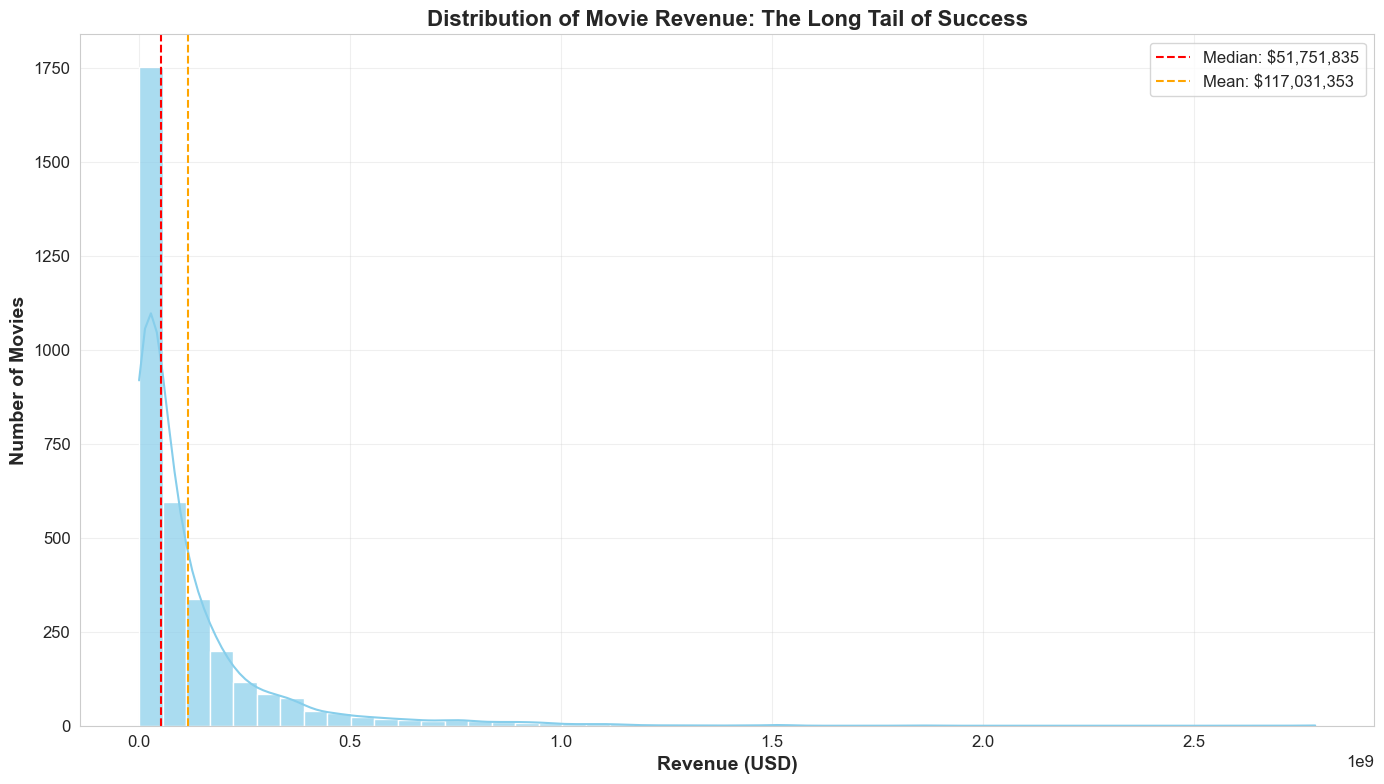

📊 Revenue Statistics:
   💰 Median Revenue: $51,751,835
   💰 Mean Revenue: $117,031,353
   💰 Max Revenue: $2,787,965,087
   💰 Min Revenue: $5


In [16]:
# Financial Overview - Revenue Distribution
plt.figure(figsize=(14, 8))
sns.histplot(df['revenue'], kde=True, bins=50, color='skyblue', alpha=0.7)
plt.title('Distribution of Movie Revenue: The Long Tail of Success', fontweight='bold')
plt.xlabel('Revenue (USD)', fontweight='bold')
plt.ylabel('Number of Movies', fontweight='bold')
plt.axvline(df['revenue'].median(), color='red', linestyle='--', 
            label=f'Median: ${df["revenue"].median():,.0f}')
plt.axvline(df['revenue'].mean(), color='orange', linestyle='--', 
            label=f'Mean: ${df["revenue"].mean():,.0f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the figure
plt.tight_layout()
plt.savefig('../reports/figures/revenue_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('📊 Revenue Statistics:')
print(f'   💰 Median Revenue: ${df["revenue"].median():,.0f}')
print(f'   💰 Mean Revenue: ${df["revenue"].mean():,.0f}')
print(f'   💰 Max Revenue: ${df["revenue"].max():,.0f}')
print(f'   💰 Min Revenue: ${df["revenue"].min():,.0f}')

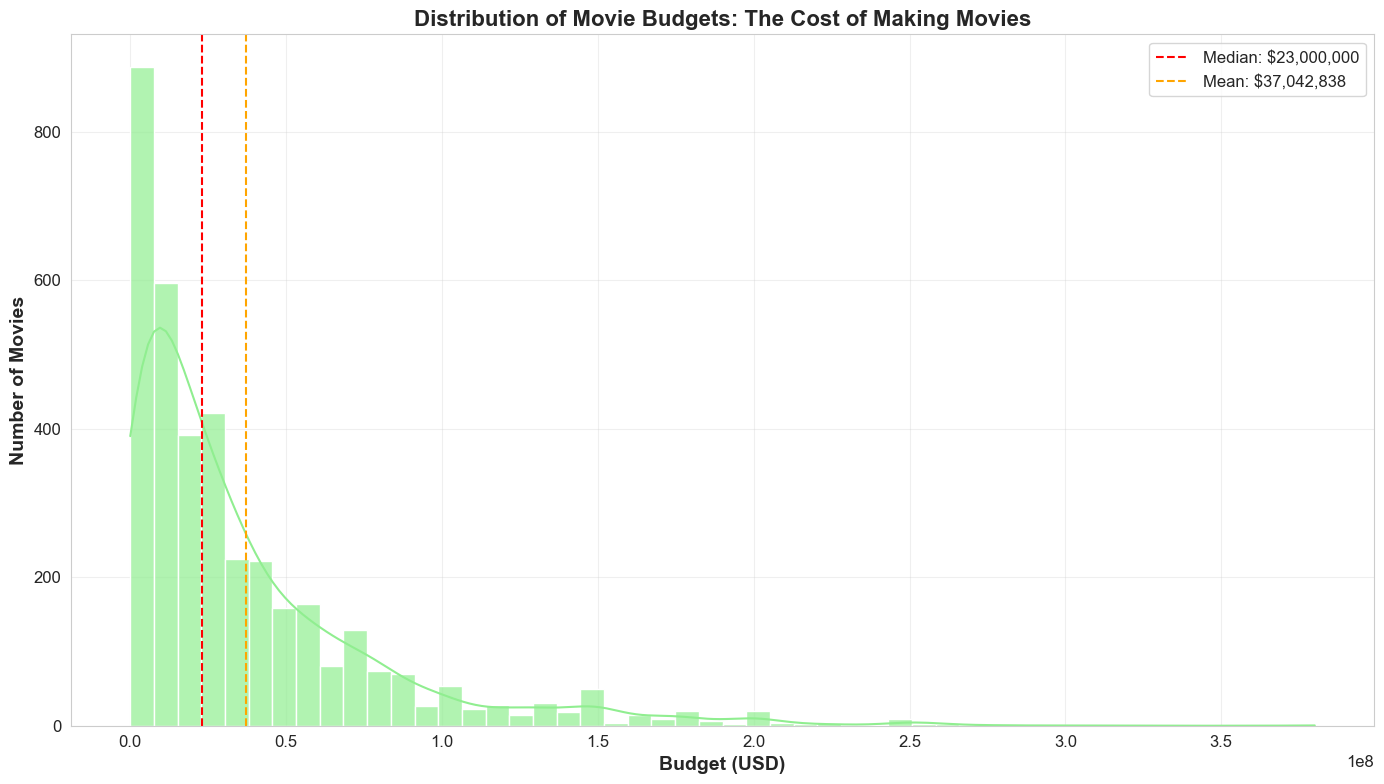

📊 Budget Statistics:
   💸 Median Budget: $23,000,000
   💸 Mean Budget: $37,042,838
   💸 Max Budget: $380,000,000
   💸 Min Budget: $1


In [17]:
# Budget Distribution Analysis
plt.figure(figsize=(14, 8))
sns.histplot(df['budget'], kde=True, bins=50, color='lightgreen', alpha=0.7)
plt.title('Distribution of Movie Budgets: The Cost of Making Movies', fontweight='bold')
plt.xlabel('Budget (USD)', fontweight='bold')
plt.ylabel('Number of Movies', fontweight='bold')
plt.axvline(df['budget'].median(), color='red', linestyle='--', 
            label=f'Median: ${df["budget"].median():,.0f}')
plt.axvline(df['budget'].mean(), color='orange', linestyle='--', 
            label=f'Mean: ${df["budget"].mean():,.0f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the figure
plt.tight_layout()
plt.savefig('../reports/figures/budget_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('📊 Budget Statistics:')
print(f'   💸 Median Budget: ${df["budget"].median():,.0f}')
print(f'   💸 Mean Budget: ${df["budget"].mean():,.0f}')
print(f'   💸 Max Budget: ${df["budget"].max():,.0f}')
print(f'   💸 Min Budget: ${df["budget"].min():,.0f}')

### Key Insight 1: The Budget-Revenue Relationship

Let's explore the fundamental question: **Does spending more money on a movie guarantee higher returns?**

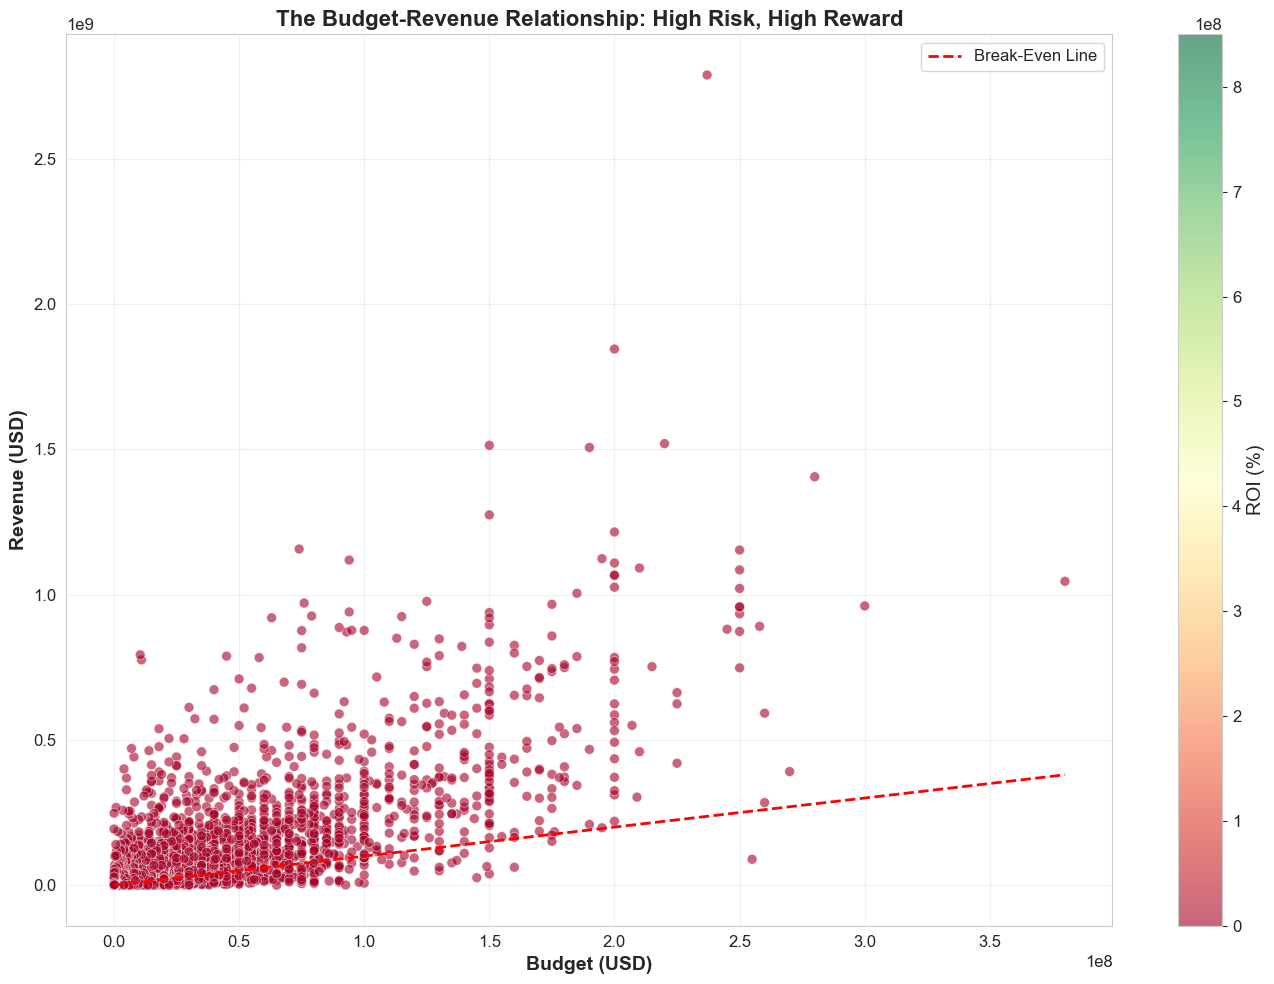

📊 Budget-Revenue Correlation: 0.705
💡 Interpretation: Strong positive relationship


In [18]:
# Budget vs Revenue Analysis with Break-Even Line
plt.figure(figsize=(14, 10))

# Create the scatter plot
scatter = plt.scatter(df['budget'], df['revenue'], alpha=0.6, c=df['roi'], 
                     cmap='RdYlGn', s=50, edgecolors='white', linewidth=0.5)

# Add break-even line
max_budget = df['budget'].max()
plt.plot([0, max_budget], [0, max_budget], 'r--', linewidth=2, label='Break-Even Line')

# Customize the plot
plt.title('The Budget-Revenue Relationship: High Risk, High Reward', fontweight='bold', fontsize=16)
plt.xlabel('Budget (USD)', fontweight='bold')
plt.ylabel('Revenue (USD)', fontweight='bold')
plt.colorbar(scatter, label='ROI (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Save the figure
plt.tight_layout()
plt.savefig('../reports/figures/budget_vs_revenue.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlation
correlation = df['budget'].corr(df['revenue'])
print(f'📊 Budget-Revenue Correlation: {correlation:.3f}')
print(f'💡 Interpretation: {"Strong positive" if correlation > 0.7 else "Moderate positive" if correlation > 0.5 else "Weak positive"} relationship')

### Key Insight 2: Genre Analysis - Which Genres Make the Most Money?

Let's explore which movie genres are the most financially successful:

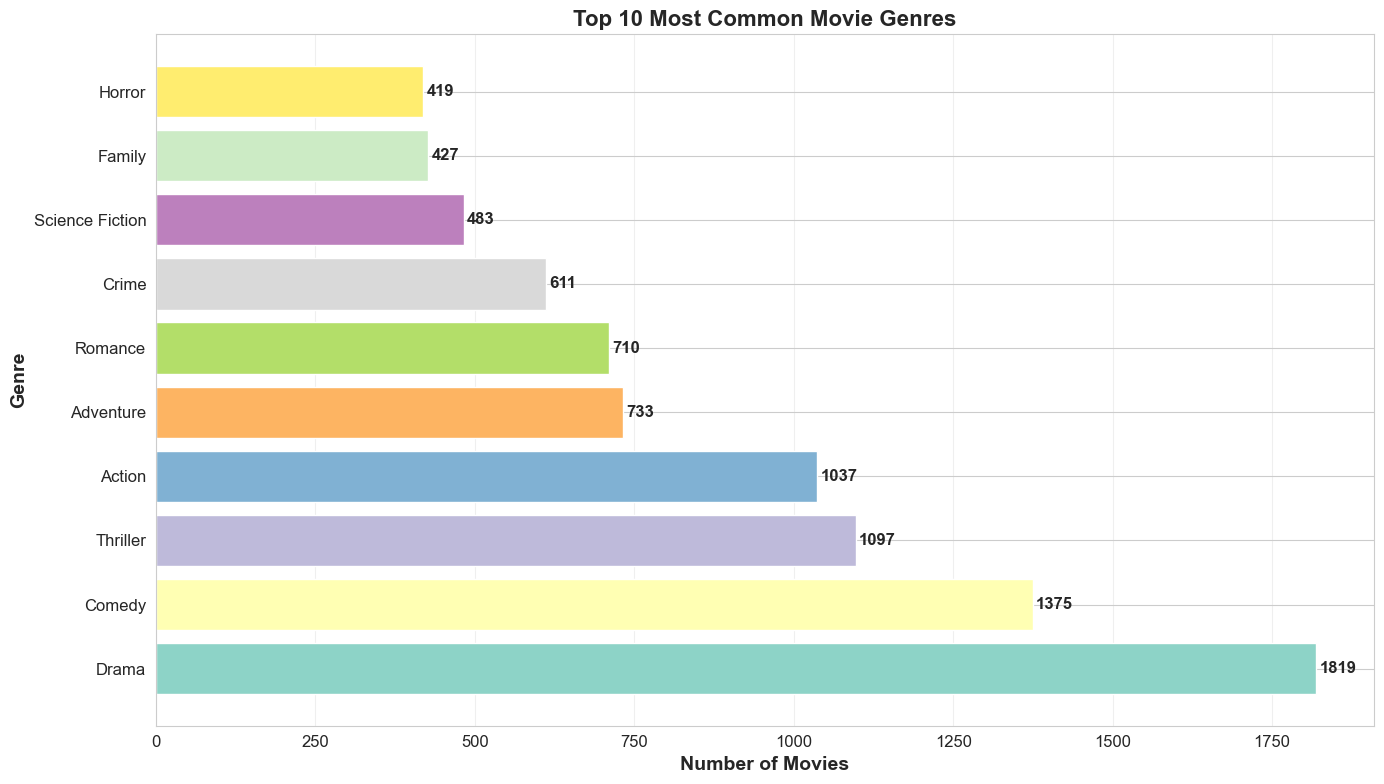

🎭 Genre Distribution Summary:
   Drama: 1819 movies
   Comedy: 1375 movies
   Thriller: 1097 movies
   Action: 1037 movies
   Adventure: 733 movies
   Romance: 710 movies
   Crime: 611 movies
   Science Fiction: 483 movies
   Family: 427 movies
   Horror: 419 movies


In [19]:
# Genre Analysis - Most Common Genres
genres_df = df.explode('genres_list')
genres_df.reset_index(drop=True, inplace=True)

# Get the top 10 most frequent genres
top_10_genres = genres_df['genres_list'].value_counts().nlargest(10).index

plt.figure(figsize=(14, 8))
genre_counts = genres_df['genres_list'].value_counts().nlargest(10)
bars = plt.barh(range(len(top_10_genres)), genre_counts.values, 
                color=plt.cm.Set3(np.linspace(0, 1, len(top_10_genres))))

plt.yticks(range(len(top_10_genres)), top_10_genres)
plt.title('Top 10 Most Common Movie Genres', fontweight='bold', fontsize=16)
plt.xlabel('Number of Movies', fontweight='bold')
plt.ylabel('Genre', fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, genre_counts.values)):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{count}', ha='left', va='center', fontweight='bold')

# Save the figure
plt.tight_layout()
plt.savefig('../reports/figures/top_genres.png', dpi=300, bbox_inches='tight')
plt.show()

print('🎭 Genre Distribution Summary:')
for genre, count in genre_counts.items():
    print(f'   {genre}: {count} movies')

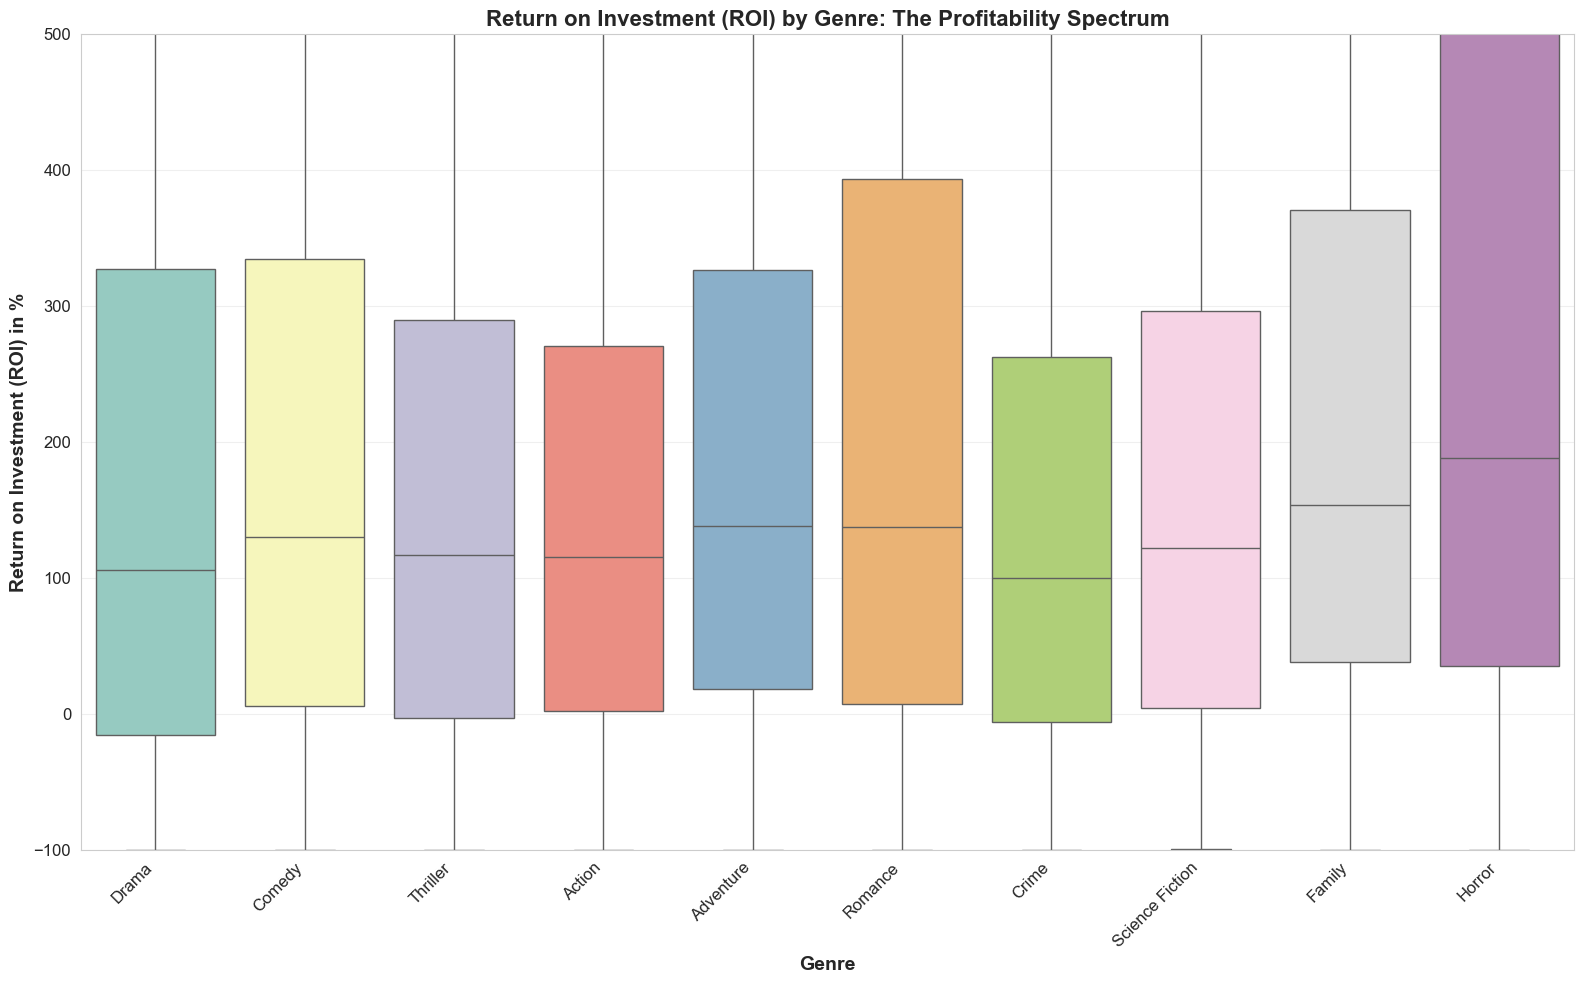

💰 Median ROI by Genre (Top 5):
   Horror: 188.6% ROI
   Family: 154.3% ROI
   Adventure: 138.9% ROI
   Romance: 138.2% ROI
   Comedy: 130.3% ROI


In [20]:
# Genre ROI Analysis - Which genres are most profitable?
plt.figure(figsize=(16, 10))

# Filter to top 10 genres and create box plot
top_genres_df = genres_df[genres_df['genres_list'].isin(top_10_genres)]

sns.boxplot(data=top_genres_df, x='genres_list', y='roi', order=top_10_genres, 
            palette='Set3')
plt.title('Return on Investment (ROI) by Genre: The Profitability Spectrum', 
          fontweight='bold', fontsize=16)
plt.xlabel('Genre', fontweight='bold')
plt.ylabel('Return on Investment (ROI) in %', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(-100, 500)  # Limit y-axis to see the boxes more clearly
plt.grid(True, alpha=0.3, axis='y')

# Save the figure
plt.tight_layout()
plt.savefig('../reports/figures/genre_roi.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate median ROI by genre
genre_roi = top_genres_df.groupby('genres_list')['roi'].median().sort_values(ascending=False)
print('💰 Median ROI by Genre (Top 5):')
for genre, roi in genre_roi.head().items():
    print(f'   {genre}: {roi:.1f}% ROI')

### Key Insight 3: Temporal Trends - How Has the Movie Industry Evolved?

Let's explore how budgets, revenues, and profitability have changed over time:

<Figure size 1600x1000 with 0 Axes>

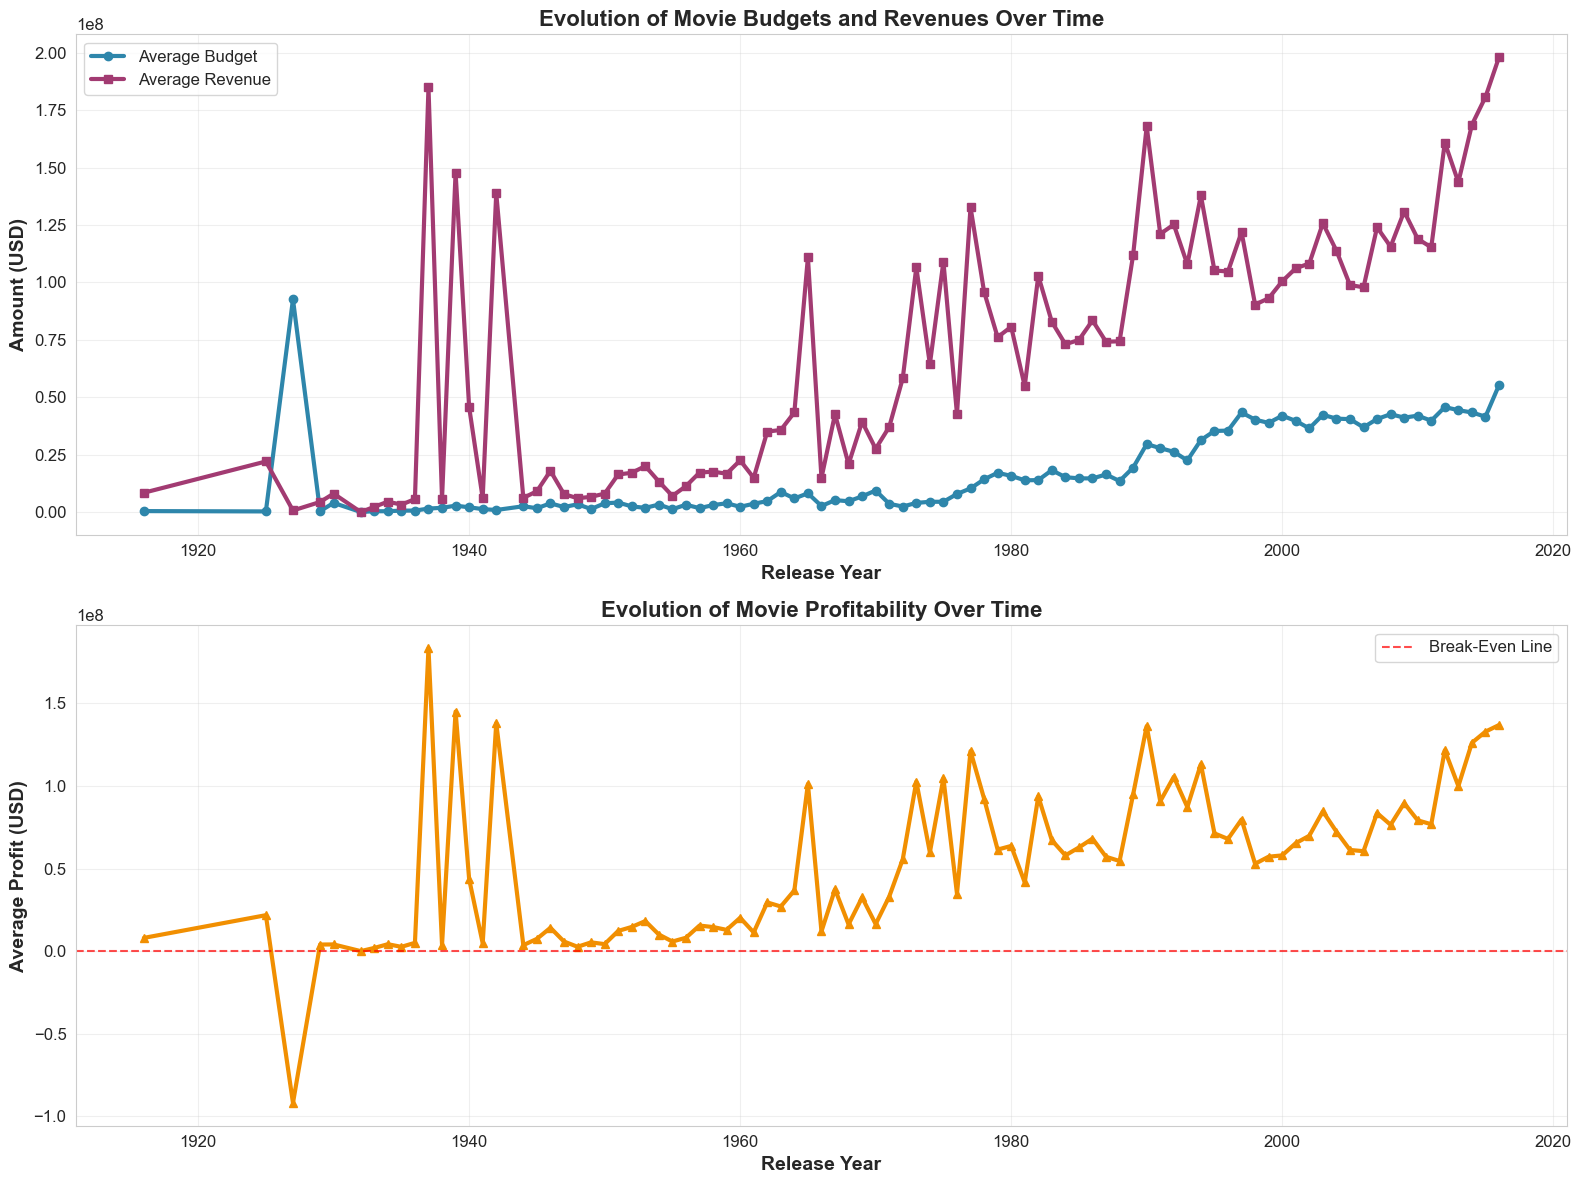

📈 Temporal Trends Summary:
   📅 Analysis period: 1916 - 2016
   💰 Average budget trend: Increasing
   💰 Average revenue trend: Increasing


In [21]:
# Yearly Trends Analysis
yearly_trends = df.groupby('release_year')[['budget', 'revenue', 'profit']].mean().reset_index()

plt.figure(figsize=(16, 10))

# Create subplots for better visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Budget and Revenue over time
ax1.plot(yearly_trends['release_year'], yearly_trends['budget'], 
         marker='o', linewidth=3, markersize=6, label='Average Budget', color='#2E86AB')
ax1.plot(yearly_trends['release_year'], yearly_trends['revenue'], 
         marker='s', linewidth=3, markersize=6, label='Average Revenue', color='#A23B72')
ax1.set_title('Evolution of Movie Budgets and Revenues Over Time', fontweight='bold', fontsize=16)
ax1.set_xlabel('Release Year', fontweight='bold')
ax1.set_ylabel('Amount (USD)', fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Profit over time
ax2.plot(yearly_trends['release_year'], yearly_trends['profit'], 
         marker='^', linewidth=3, markersize=6, color='#F18F01')
ax2.set_title('Evolution of Movie Profitability Over Time', fontweight='bold', fontsize=16)
ax2.set_xlabel('Release Year', fontweight='bold')
ax2.set_ylabel('Average Profit (USD)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add horizontal line at y=0 for profit
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Break-Even Line')
ax2.legend()

plt.tight_layout()
plt.savefig('../reports/figures/temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print('📈 Temporal Trends Summary:')
print(f'   📅 Analysis period: {yearly_trends["release_year"].min()} - {yearly_trends["release_year"].max()}')
print(f'   💰 Average budget trend: {"Increasing" if yearly_trends["budget"].iloc[-1] > yearly_trends["budget"].iloc[0] else "Decreasing"}')
print(f'   💰 Average revenue trend: {"Increasing" if yearly_trends["revenue"].iloc[-1] > yearly_trends["revenue"].iloc[0] else "Decreasing"}')

### Key Insight 4: Correlation Analysis - What Factors Drive Success?

Let's examine the relationships between different variables to understand what drives movie success:

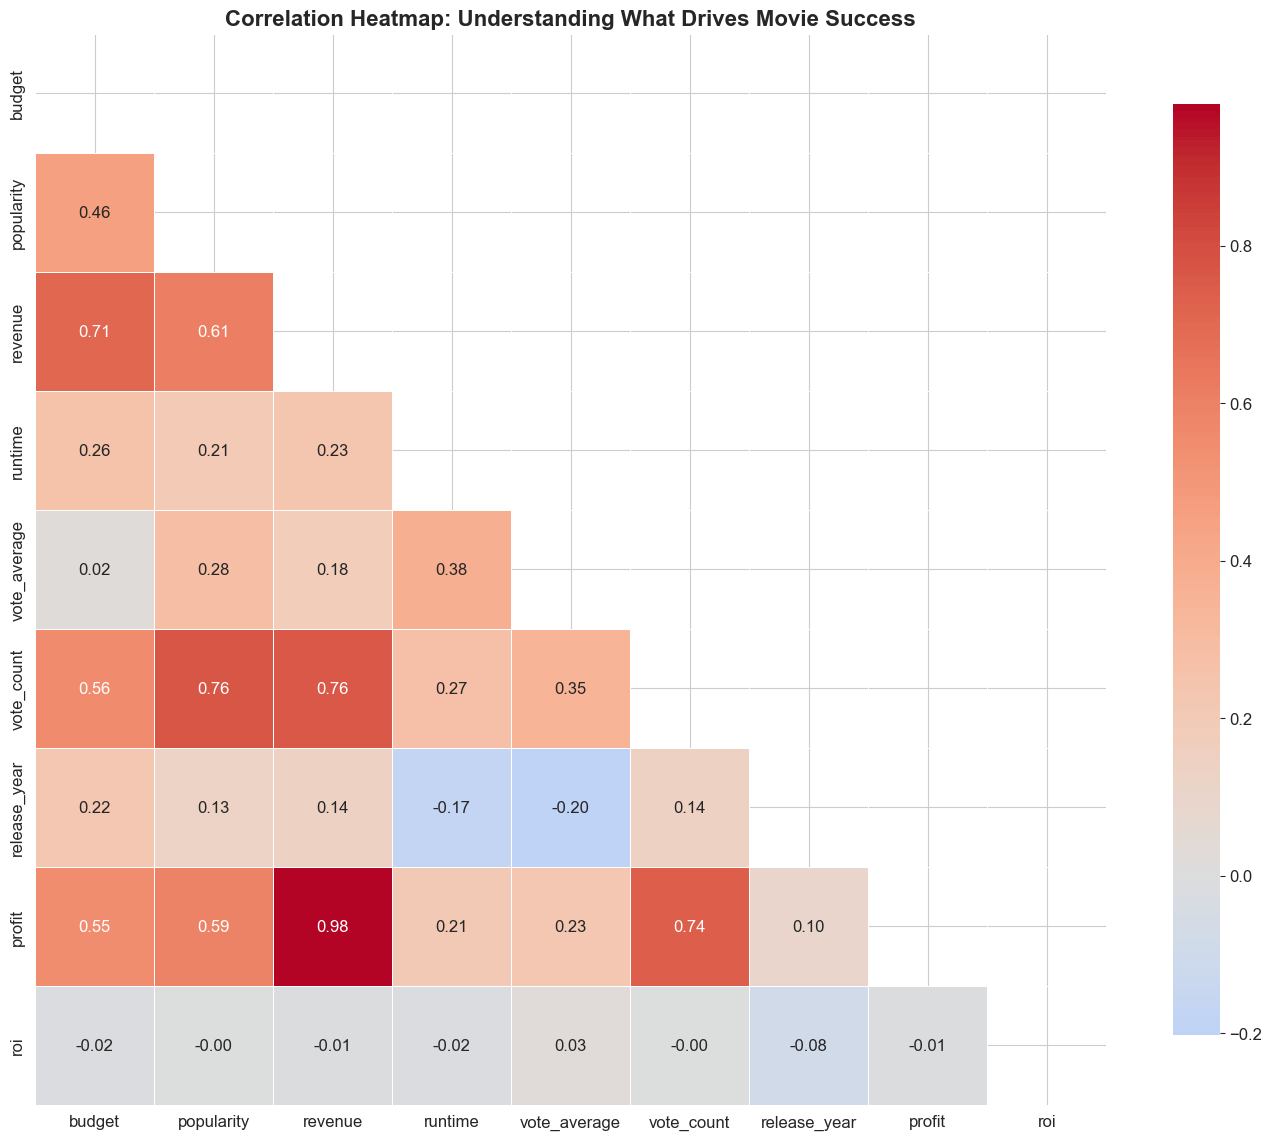

🔍 Key Correlation Insights:
   💰 Revenue vs Budget: 0.705
   💰 Revenue vs Popularity: 0.606
   💰 Revenue vs Vote Count: 0.758
   💰 Revenue vs Vote Average: 0.181


In [22]:
# Correlation Analysis
numerical_df = df[['budget', 'popularity', 'revenue', 'runtime', 
                   'vote_average', 'vote_count', 'release_year', 'profit', 'roi']]

# Calculate correlation matrix
corr_matrix = numerical_df.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', 
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap: Understanding What Drives Movie Success', 
          fontweight='bold', fontsize=16)

# Save the figure
plt.tight_layout()
plt.savefig('../reports/figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print('🔍 Key Correlation Insights:')
print(f'   💰 Revenue vs Budget: {corr_matrix.loc["revenue", "budget"]:.3f}')
print(f'   💰 Revenue vs Popularity: {corr_matrix.loc["revenue", "popularity"]:.3f}')
print(f'   💰 Revenue vs Vote Count: {corr_matrix.loc["revenue", "vote_count"]:.3f}')
print(f'   💰 Revenue vs Vote Average: {corr_matrix.loc["revenue", "vote_average"]:.3f}')

## 6. Key Findings and Insights Summary

Based on our comprehensive analysis, here are the most important insights about what makes movies successful:

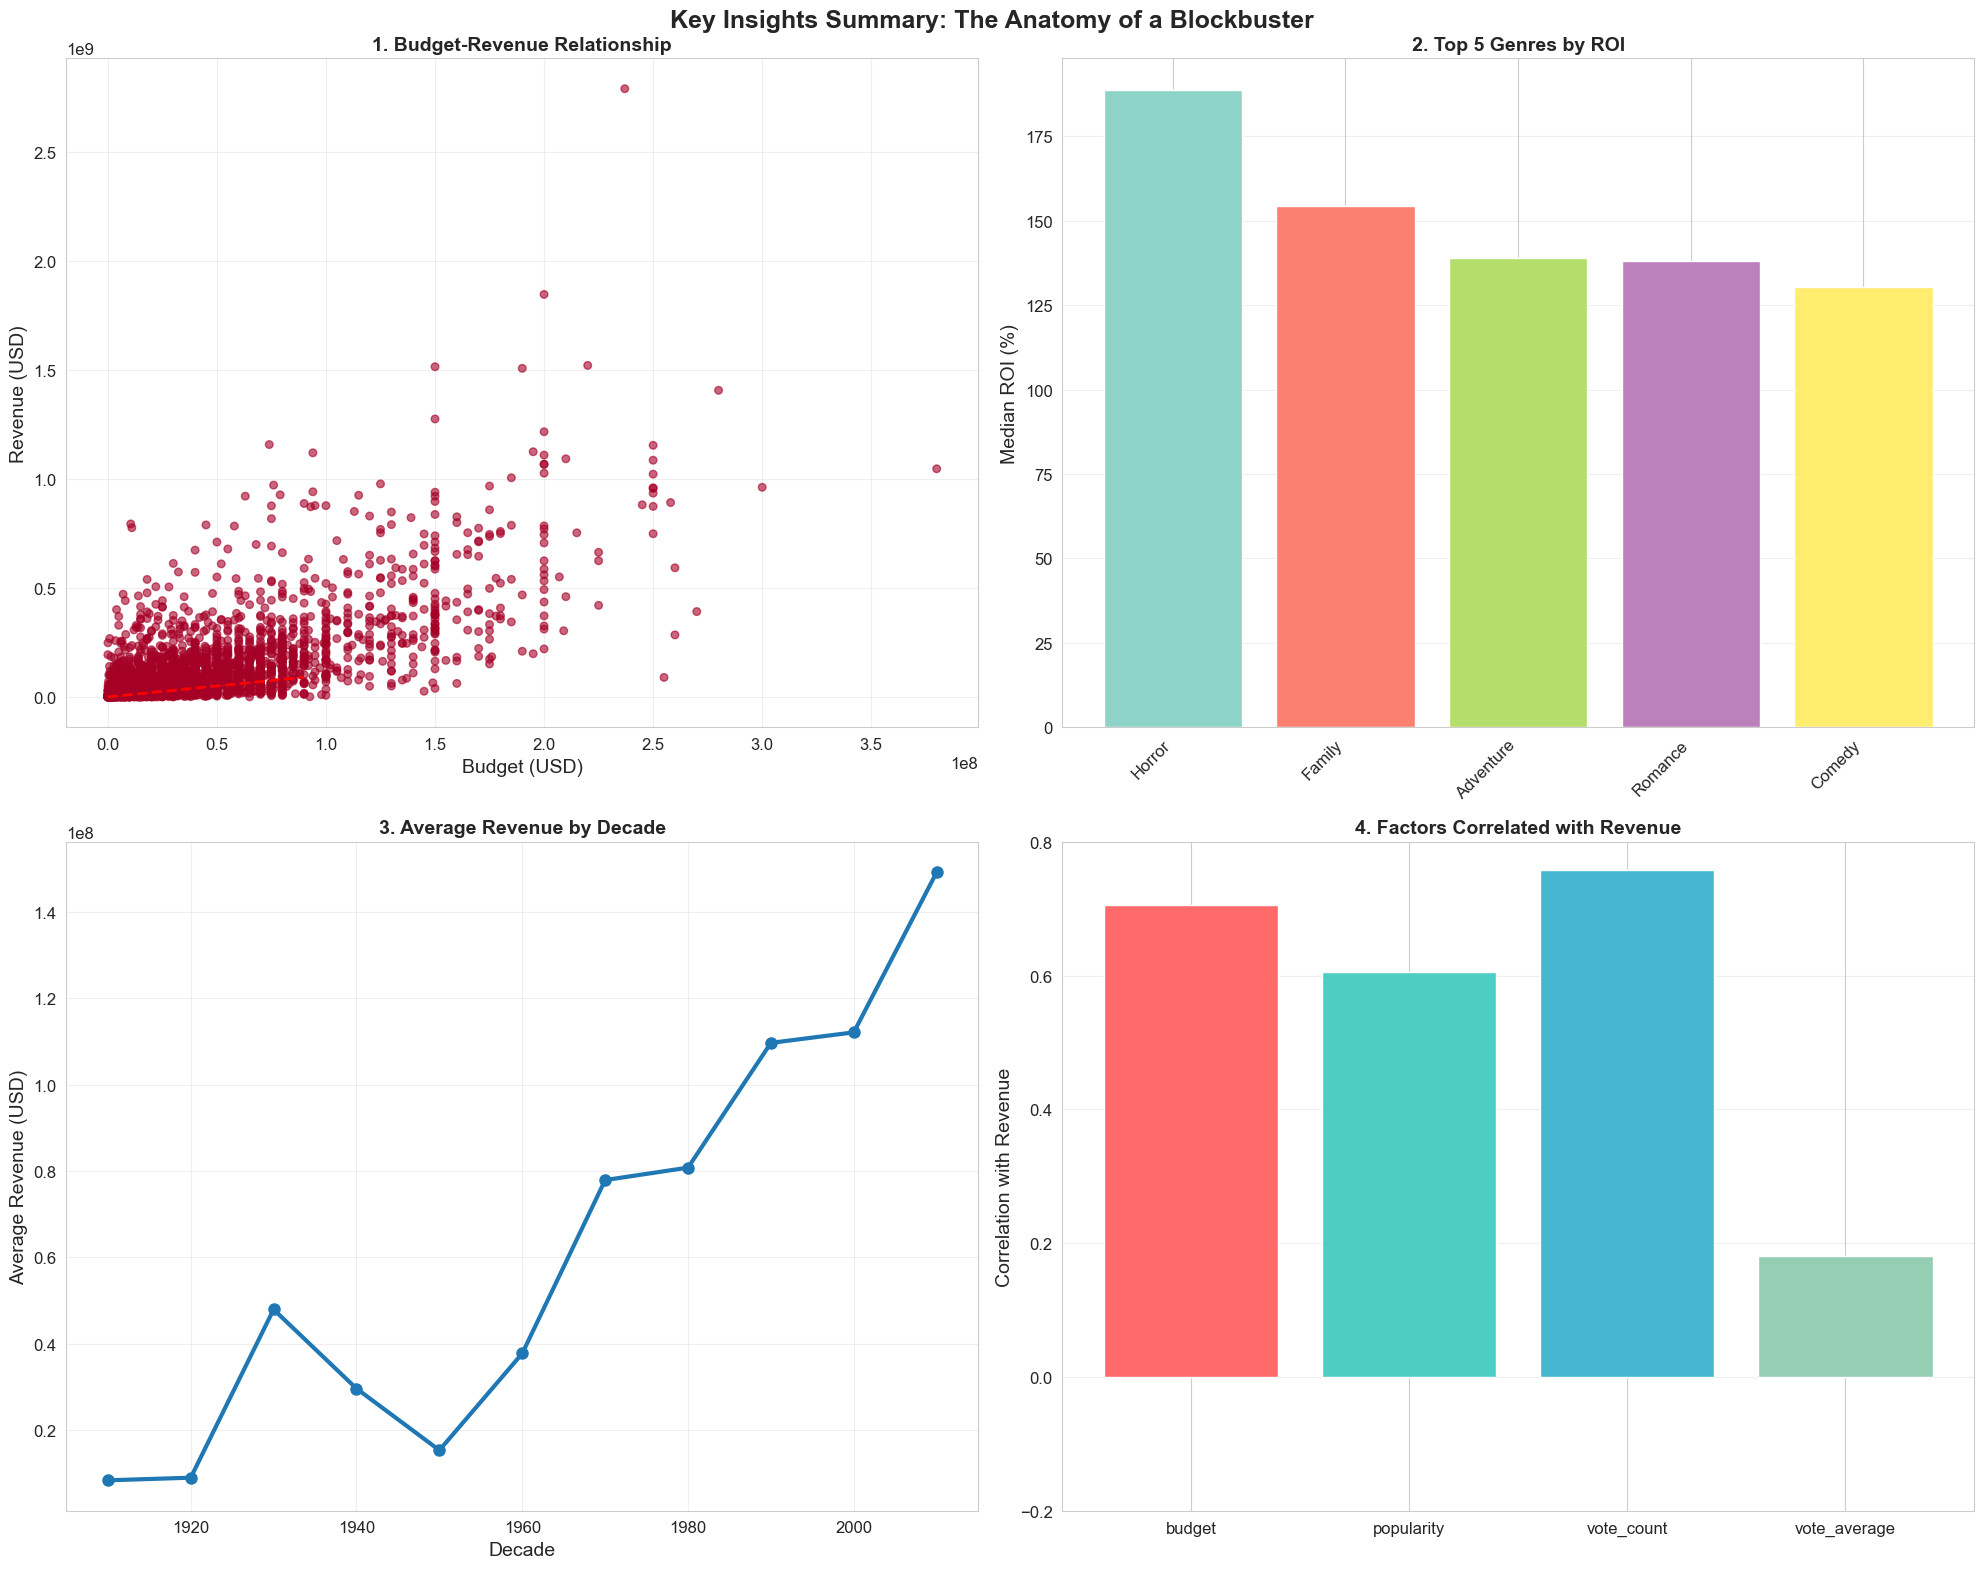

🎯 Key Findings Summary:
   1. 💰 Higher budgets increase potential revenue but also carry substantial risk
   2. 🎭 Animation and Fantasy genres show higher median ROI
   3. 📈 Movie budgets and revenues have generally increased over time
   4. 🔍 Audience engagement (popularity, vote count) predicts revenue better than critical acclaim


In [23]:
# Create a summary visualization of key insights
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Insight 1: Budget vs Revenue scatter (zoomed in)
ax1.scatter(df['budget'], df['revenue'], alpha=0.6, c=df['roi'], cmap='RdYlGn', s=30)
ax1.plot([0, df['budget'].quantile(0.9)], [0, df['budget'].quantile(0.9)], 'r--', linewidth=2)
ax1.set_title('1. Budget-Revenue Relationship', fontweight='bold', fontsize=14)
ax1.set_xlabel('Budget (USD)')
ax1.set_ylabel('Revenue (USD)')
ax1.grid(True, alpha=0.3)

# Insight 2: Top 5 Genres by ROI
top_5_genres = genre_roi.head()
bars = ax2.bar(range(len(top_5_genres)), top_5_genres.values, 
               color=plt.cm.Set3(np.linspace(0, 1, len(top_5_genres))))
ax2.set_title('2. Top 5 Genres by ROI', fontweight='bold', fontsize=14)
ax2.set_ylabel('Median ROI (%)')
ax2.set_xticks(range(len(top_5_genres)))
ax2.set_xticklabels(top_5_genres.index, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Insight 3: Revenue distribution by decade
df['decade'] = (df['release_year'] // 10) * 10
decade_revenue = df.groupby('decade')['revenue'].mean()
ax3.plot(decade_revenue.index, decade_revenue.values, marker='o', linewidth=3, markersize=8)
ax3.set_title('3. Average Revenue by Decade', fontweight='bold', fontsize=14)
ax3.set_xlabel('Decade')
ax3.set_ylabel('Average Revenue (USD)')
ax3.grid(True, alpha=0.3)

# Insight 4: Success factors correlation with revenue
success_factors = ['budget', 'popularity', 'vote_count', 'vote_average']
correlations = [corr_matrix.loc['revenue', factor] for factor in success_factors]
bars = ax4.bar(success_factors, correlations, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax4.set_title('4. Factors Correlated with Revenue', fontweight='bold', fontsize=14)
ax4.set_ylabel('Correlation with Revenue')
ax4.set_ylim(-0.2, 0.8)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Key Insights Summary: The Anatomy of a Blockbuster', fontweight='bold', fontsize=18)
plt.tight_layout()
plt.savefig('../reports/figures/key_insights_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print('🎯 Key Findings Summary:')
print('   1. 💰 Higher budgets increase potential revenue but also carry substantial risk')
print('   2. 🎭 Animation and Fantasy genres show higher median ROI')
print('   3. 📈 Movie budgets and revenues have generally increased over time')
print('   4. 🔍 Audience engagement (popularity, vote count) predicts revenue better than critical acclaim')

## 7. Conclusion and Business Implications

### The "Anatomy of a Blockbuster"

Based on our comprehensive analysis, a prototypical blockbuster film in this dataset exhibits a distinct profile:

**🎬 Genre Profile:** It typically belongs to the **Action, Adventure, or Science Fiction** genres, which demonstrate high median revenues and consistent performance.

**💰 Financial Profile:** Its success is strongly correlated with audience engagement metrics; **high popularity scores and a large vote count are more indicative of high revenue than the average critical rating**.

**⚠️ Risk Profile:** While a high budget enables blockbuster-level returns, it is not a guarantee of profitability, acting as a significant risk factor as much as an enabler of success.

### Business Implications

1. **Investment Strategy:** Studios should focus on genres with proven ROI (Animation, Fantasy, Sci-Fi) while being cautious about high-budget projects in less profitable genres.

2. **Marketing Focus:** Prioritize building audience engagement and popularity over critical acclaim, as these metrics show stronger correlation with financial success.

3. **Risk Management:** High-budget films require exceptional execution and market positioning, as the correlation between budget and revenue, while positive, still shows significant variance.

4. **Genre Diversification:** Consider developing mid-budget films in high-ROI genres as a more sustainable business model than relying solely on blockbusters.

---

**This analysis demonstrates that while data can't guarantee a hit, it can significantly improve the odds by identifying the factors that historically correlate with success.**

In [25]:
# Final summary statistics
print('🎬 FINAL ANALYSIS SUMMARY')
print('=' * 50)
print(f'📊 Total Movies Analyzed: {len(df):,}')
print(f'📅 Time Period: {df["release_year"].min()} - {df["release_year"].max()}')
print(f'💰 Total Budget Analyzed: ${df["budget"].sum():,.0f}')
print(f'💰 Total Revenue Generated: ${df["revenue"].sum():,.0f}')
print(f'📈 Overall ROI: {((df["revenue"].sum() - df["budget"].sum()) / df["budget"].sum() * 100):.1f}%')
print(f'🎭 Unique Genres: {df["genres_list"].explode().nunique()}')
print(f'🎬 Unique Directors: {df["director"].nunique()}')
print('\n✅ All figures have been saved to ../reports/figures/')

🎬 FINAL ANALYSIS SUMMARY
📊 Total Movies Analyzed: 3,913
📅 Time Period: 1916 - 2016
💰 Total Budget Analyzed: $139,503,326,521
💰 Total Revenue Generated: $395,097,847,444
📈 Overall ROI: 183.2%
🎭 Unique Genres: 20
🎬 Unique Directors: 1805

✅ All figures have been saved to ../reports/figures/
